In [1]:
from datetime import datetime, timedelta
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

sys.path.append('..')
from util.batcher import Batcher
#from util.stock_loader import Loader

In [2]:
TODAY = datetime.now().date()
TOMORROW  = TODAY + timedelta(1)
TOMORROW

datetime.date(2022, 11, 5)

In [3]:
DATA = '../data'

sp1950 = pd.read_csv(f'{DATA}/sp1950.csv')
nya1965 = pd.read_csv(f'{DATA}/nya1965.csv')
nasdaq1965 = pd.read_csv(f'{DATA}/nasdaq1965.csv')
wilshire1990 = pd.read_csv(f'{DATA}/wilshire1990.csv')


nasdaq1965.tail()
states = pd.read_csv(f'{DATA}/hmm_exp_returns.csv')
states.index = pd.to_datetime(states.Date)
states.tail()

,Date,sp,sp_daily,sp_exp,nyse,nyse_daily,nyse_exp,nas,nas_daily,nas_exp,wil,wil_daily,wil_exp,mean_exp,state
Date,,,,,,,,,,,,,,,
2022-10-31,2022-10-31,3871.979980,0.992546,0.99998,14747.030273,0.996715,0.999858,10988.150391,0.989705,1.000438,38702.500000,0.993577,0.999567,0.999961,0
2022-11-01,2022-11-01,3856.100098,0.995899,0.99998,14790.709961,1.002962,0.999858,10890.849609,0.991145,1.000438,38575.718750,0.996724,0.999567,0.999961,0
2022-11-02,2022-11-02,3759.689941,0.974998,0.99998,14497.849609,0.980200,0.999858,10524.799805,0.966389,1.000438,37563.921875,0.973771,0.999567,0.999961,0
2022-11-03,2022-11-03,3719.889893,0.989414,0.99998,14455.669922,0.997091,0.999858,10342.940430,0.982721,1.000438,37195.031250,0.990180,0.999567,0.999961,0
2022-11-04,2022-11-04,3770.550049,1.013619,0.99998,14702.774414,1.017094,0.999858,10475.254883,1.012793,1.000438,37635.453125,1.011841,0.999567,0.999961,0


In [4]:
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'ACN', 'ADBE', 'ADYEY', 'AMD', 'AMGN',
    'AMZN', 'ANET', 'ASML', 'AXON', 'BROS', 'BYND', 'CHWY', 'CRWD',
    'DDOG', 'DOCS', 'DOCU', 'DUOL', 'EDIT', 'ETSY', 'FLGT', 'GH',
    'GMED', 'GOOG', 'IDXX', 'INTG', 'ISRG', 'JD', 'LRCX', 'LSPD',
    'LULU', 'MDB', 'MELI', 'MNST', 'MSFT', 'MTCH', 'NVCR', 'NVDA',
    'ODFL', 'OKTA', 'OPEN', 'PAC', 'PANW', 'PAYC', 'PINS', 'PTON',
    'PYPL', 'QDEL', 'RBLX', 'RDFN', 'RGEN', 'RIVN', 'RMD', 'ROKU',
    'RVLV', 'SE', 'SHOP', 'SNOW', 'TASK', 'TDOC', 'TEAM', 'TREX',
    'TSCO', 'TSLA', 'TTD', 'TTWO', 'TWLO', 'TWTR', 'TYL', 'UPST',
    'VEEV', 'VLD', 'VRTX', 'XPEV', 'ZEN', 'ZM']
LINGERERS = [
    'AMEH', 'AMRK', 'APT', 'CENN',
    'CTGO', 'DTST', 'EP', 'FCUV', 'FKWL', 'GGE', 'GME', 'INTZ', 'KREF',
    'LFMD', 'MCVT', 'MIY', 'MNMD', 'MOBQ', 'PETV',
    'POWW', 'PRPH', 'RVYL', 'VIRT', 'WAVD', 'WKHS', 'ZYXI']
BEST_WEIGHTED = [
    'BTTR', 'BYRN', 'CEF', 'CGAU', 'CIZN', 'DYAI', 'HMY', 'HNRG',
    'IEI', 'MGF', 'MICS', 'MIN', 'MMU', 'MUE', 'NAN', 'NXN', 'NXP',
    'OMQS', 'RVP', 'SOBR']

len(SYMBOLS)

78

In [5]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
START, TODAY

(datetime.date(2012, 11, 7), datetime.date(2022, 11, 5))

In [6]:
batch = sorted(list(set(SYMBOLS + LINGERERS + BEST_WEIGHTED)))

In [7]:
data = (
    yf
    .download(batch, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'})
    .sort_index())

[*********************100%***********************]  124 of 124 completed


In [8]:
data['state'] = states.state
data.tail()

AdjClose                                                  \
                  AAPL        ABMD        ABNB         ACN        ADBE   
Date                                                                     
2022-10-31  153.339996  252.080002  106.910004  283.899994  318.500000   
2022-11-01  150.649994  377.820007  109.050003  281.470001  316.019989   
2022-11-02  145.029999  373.510010   94.410004  272.450012  301.220001   
2022-11-03  138.880005  373.630005   92.019997  256.880005  285.929993   
2022-11-04  138.380005  373.989990   96.089996  261.160004  285.750000   

                                                                 ...  \
             ADYEY        AMD       AMEH        AMGN       AMRK  ...   
Date                                                             ...   
2022-10-31  14.370  60.060001  35.459999  270.350006  30.410000  ...   
2022-11-01  14.109  59.660000  35.230000  272.059998  30.420000  ...   
2022-11-02  13.689  58.630001  34.939999  269.010010  30.049999  ...   
2022-11-03  12.790  60.110001  33.230000  265.880005  28.580000  ...   
2022-11-04  12.930  62.189999  37.950001  269.040009  28.700001  ...   

               Volume                                                 \
                 VIRT       VLD     VRTX   WAVD     WKHS        XPEV   
Date                                                                   
2022-10-31   577900.0  923800.0  1575200  14900  3215900  27737800.0   
2022-11-01   434800.0  726900.0  1192500   4400  1971900  39135600.0   
2022-11-02   982200.0  976000.0  1492900  24700  2476700  49040500.0   
2022-11-03   866800.0  686300.0   936000  58200  3397800  23702300.0   
2022-11-04  1021089.0  925555.0  1125476    996  4547416  60166365.0   

                                         state  
                  ZEN         ZM    ZYXI        
Date                                            
2022-10-31  1420600.0  1908600.0  441700     0  
2022-11-01  1851800.0  1834900.0  537300     0  
2022-11-02  2562200.0  3381000.0  403900     0  
2022-11-03  1160400.0  3156400.0  310200     0  
2022-11-04  1984333.0  3468278.0  233217     0  

[5 rows x 745 columns]

In [9]:
STATES = sorted(states.state.unique())
STATES

[0, 1, 2, 3, 4, 5, 6]

In [10]:
CURRENT_STATE = states.state[-1]
CURRENT_STATE

0

In [11]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock]]
    first_value = (
        sub.AdjClose[stock][sub.AdjClose[stock].notna()].index[0])
    sub = sub.loc[first_value:, :]
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    sub.fillna(method='ffill', inplace=True)
    return sub

In [12]:
def get_daily_returns(x):
    idx = x.index
    n = len(x)
    x = np.array(x)
    #return x[2:n] / x[1:(n - 1)] - 1 
    returns = x[1:n] / x[0:(n-1)] - 1
    returns = pd.Series(returns, index=idx[1:])
    return returns

In [13]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [14]:
def get_hedged_sharpe(daily_returns, data):
    state_sharpe = get_sharpe(
        daily_returns[data.state == CURRENT_STATE])
    lower_state_sharpe = get_sharpe(
        daily_returns[data.state == max(CURRENT_STATE - 1, 0)])
    upper_state_sharpe = get_sharpe(
        daily_returns[
            data.state == min(CURRENT_STATE + 1, max(STATES))])
    return min(state_sharpe, lower_state_sharpe, upper_state_sharpe)

In [15]:
def get_weighted_sharpe(daily_returns, data, weights=[0.2, 0.6, 0.2]):
    state_sharpe = get_sharpe(
        daily_returns[data.state == CURRENT_STATE])
    lower_state_sharpe = get_sharpe(
        daily_returns[data.state == max(CURRENT_STATE - 1, 0)])
    upper_state_sharpe = get_sharpe(
        daily_returns[
            data.state == min(CURRENT_STATE + 1, max(STATES))])
    return (
        weights[0]*lower_state_sharpe
        + weights[1]*state_sharpe
        + weights[2]*upper_state_sharpe)

In [16]:
def rescale(a):
    a = a - a.min()
    a = a / a.max()
    return a

In [17]:
def vals_to_quantiles(a):
    n = len(a)
    qs = np.linspace(0, 1, n)
    order = np.argsort(a)
    out = qs[order]
    return out

In [18]:
def get_rsi(stock_data, window=14):
    df = stock_data.copy()
    df['deltas'] = df.AdjClose.diff(1)
    df['gains'] = df.deltas.clip(lower=0)
    df['losses'] = df.deltas.clip(upper=0).abs()
    df['avg_gain'] = (df.gains
                      .rolling(window=window, min_periods=window)
                      .mean()[:window + 1])
    df['avg_loss'] = (df.losses
                      .rolling(window=window, min_periods=window)
                      .mean()[:window + 1])
    
    # avg gains
    pd.options.mode.chained_assignment = None
    for i, row in enumerate(df.avg_gain.iloc[window + 1:]):
        df.avg_gain.iloc[i + window + 1] = (
            (df.avg_gain.iloc[i + window] * (window - 1) 
             + df.gains.iloc[i + window + 1]) 
            / window)
    # avg losses
    for i, row in enumerate(df.avg_loss.iloc[window + 1:]):
        df.avg_loss.iloc[i + window + 1] = (
            (df.avg_loss.iloc[i + window] * (window - 1)
             + df.losses.iloc[i + window + 1])
            / window)
    df['rs'] = df.avg_gain / df.avg_loss
    df['rsi'] = 100 - (100 / (1. + df.rs))
    return df.rsi

In [19]:
def get_macd(stock_data, fast=60, slow=90, signal=80, plot=False):
    df = stock_data.copy()
    exp1 = df.AdjClose.ewm(span=fast, adjust=False).mean()
    exp2 = df.AdjClose.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    exp3 = macd.ewm(span=signal, adjust=False).mean()
    histo = macd - exp3
    hdiff = histo.diff(1)
    is_rising = 1 * (hdiff > 0)
    if plot:
        plt.plot(macd, label='MACD', color='red')
        plt.plot(exp3, label='Signal', color='green')
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
        plt.legend();
        plt.figure()
        plt.plot(histo, color='blue')
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
        plt.axhline(y=0, color='k')
        plt.figure()
        plt.plot(is_rising)
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
    return is_rising

In [20]:
LMB = 0.9
RSI_WINDOW = 14
MACD_PARAMS = (60, 90, 80, False)

In [21]:
EXAMPLE = 'AAPL'

In [22]:
stock_data = get_stock_data(EXAMPLE, data.copy())
daily_returns = get_daily_returns(stock_data.AdjClose)
daily_returns
(get_sharpe(daily_returns), 
 get_sharpe(daily_returns[data.state == CURRENT_STATE]))

(0.8652405886345804, -2.612136078874684)

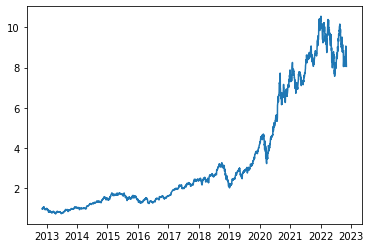

In [23]:
plt.plot(
    (get_daily_returns(data[('AdjClose', EXAMPLE)]) + 1).cumprod());

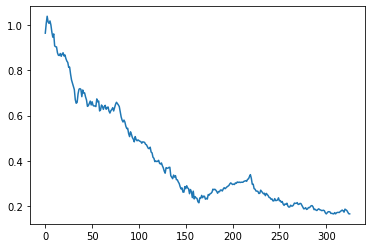

In [24]:
dr = get_daily_returns(
    data[('AdjClose', EXAMPLE)]
)[data.state == CURRENT_STATE]
dr = dr[dr.notnull()]
plt.plot((dr + 1).to_numpy().cumprod());

In [25]:
get_weighted_sharpe(daily_returns, data.copy())

-1.7636793450796233

In [26]:
def process_stock(stock, data, lmb=LMB, plot=False):
    stock_data = get_stock_data(stock, data)
    n = len(stock_data.AdjClose[~np.isnan(stock_data.AdjClose)])
    stock_data['direction'] = get_macd(stock_data, *MACD_PARAMS)
    stock_data['rsi'] = get_rsi(stock_data, window=RSI_WINDOW)
    stock_data.rsi = stock_data.rsi.rank(pct=True)
    daily_returns = get_daily_returns(stock_data.AdjClose)
    sharpe = get_sharpe(daily_returns)
    #state_sharpe = get_sharpe(
    #    daily_returns[data.state == CURRENT_STATE])
    #hedged_sharpe = get_hedged_sharpe(daily_returns, data)
    weighted_sharpe = get_weighted_sharpe(daily_returns, data)
    stock_data.fillna(method='ffill', inplace=True)
    stock_data.fillna(method='bfill', inplace=True)
    WINDOW = min(n // 2, 125)
    stock_data['ann_high'] = (
        stock_data.AdjClose.rolling(window=WINDOW).max())
    stock_data['ann_low'] = (
        stock_data.AdjClose.rolling(window=WINDOW).min())
    stock_data['drawdown'] = stock_data.AdjClose / stock_data.ann_high
    stock_data.drawdown = stock_data.drawdown.rank(pct=True)
    stock_data['pullup'] = stock_data.AdjClose / stock_data.ann_low
    stock_data.pullup = stock_data.pullup.rank(pct=True)
    w = [lmb ** t for t in range(n)][::-1]
    stock_data['W'] = w
    stock_data['n_samp'] = (stock_data.Volume / 100)  * stock_data.W
    stock_data['value'] = (
        (stock_data.AdjClose 
         + stock_data.High 
         + stock_data.Low 
         + stock_data.Open) 
        / 4)
    stock_data['est'] = np.nan
    for day in stock_data.index:
        sub = stock_data[stock_data.index <= day]
        weights = sub.n_samp
        weights = weights / weights.sum()
        values = sub.value
        est = np.dot(weights, values)
        stock_data.loc[day, 'est'] = est
    stock_data['resid'] = stock_data.AdjClose / stock_data.est
    stock_data.resid = stock_data.resid.rank(pct=True)
    stock_data.sort_values('resid', inplace=True)
    n_notnull_resid = stock_data.resid.notnull().sum()
    stock_data['dev'] = np.nan
    stock_data.loc[stock_data.resid.notnull(), 'dev'] = (
        np.array(range(n_notnull_resid) / n_notnull_resid))
    stock_data.dev = stock_data.dev.rank(pct=True)
    stock_data.sort_index(inplace=True)
    if plot:
        plt.figure(figsize=(12, 8))
        plt.plot(stock_data.AdjClose, label='AdjClose')
        plt.plot(stock_data.est, label='Est')
        plt.yscale('log')
        plt.plot(stock_data.ann_high, color='green')
        plt.plot(stock_data.ann_low, color='red')
        plt.legend();
        
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.dev)
        plt.axhline(0.5, color='k')
        plt.title(stock)
        
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.drawdown, color='red', label='drawdown')
        plt.plot(stock_data.pullup, color='green', label='pullup')
        plt.plot(
            np.sqrt(stock_data.drawdown * stock_data.pullup),
            color='grey',
            label='geomean')
        plt.yscale('log')
        plt.legend()
    return (
        stock_data.direction.tolist()[-1],
        stock_data.rsi.tolist()[-1],
        stock_data.resid.tolist()[-1], 
        stock_data.dev.tolist()[-1],
        stock_data.drawdown.tolist()[-1],
        stock_data.pullup.tolist()[-1],
        sharpe,
        #state_sharpe,
        #hedged_sharpe,
        weighted_sharpe)

(0,
 0.13423891330403515,
 0.35717123559793407,
 0.35717123559793407,
 0.07918930213121604,
 0.0829502716255746,
 0.8652405886345804,
 -1.7636793450796233)

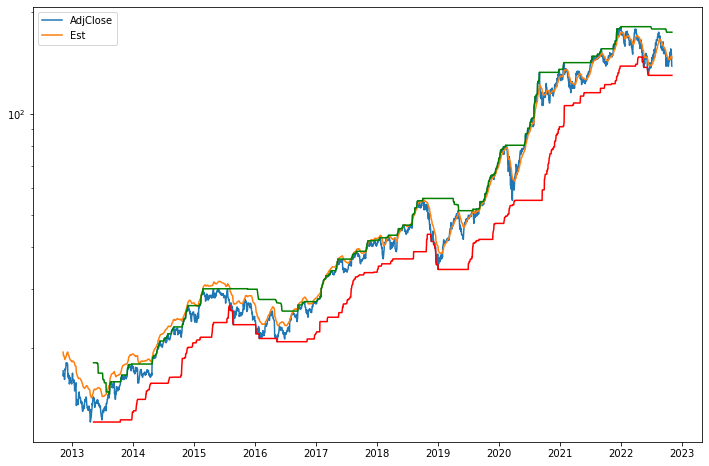

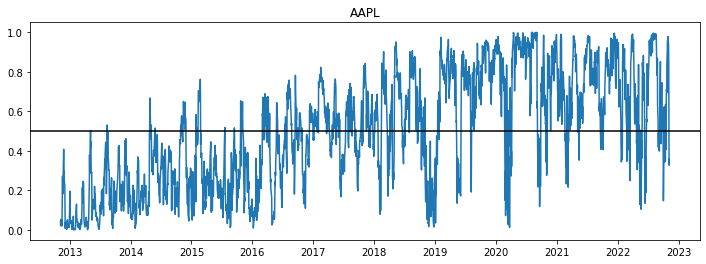

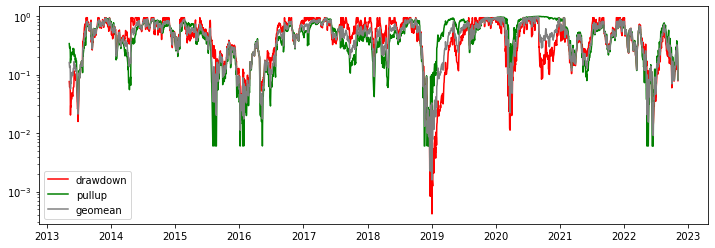

In [27]:
process_stock('AAPL', data.copy(), plot=True)

In [28]:
out = []
for stock in batch:
    print(f'{stock}...', end=' ')
    stock_stats = process_stock(stock, data)
    out.append([stock, *stock_stats])

AAPL... ABMD... ABNB... ACN... ADBE... ADYEY... AMD... AMEH... AMGN... AMRK... AMZN... ANET... APT... ASML... AXON... BROS... BTTR... BYND... BYRN... CEF... CENN... CGAU... CHWY... CIZN... CRWD... CTGO... DDOG... DOCS... DOCU... DTST... DUOL... DYAI... EDIT... EP... ETSY... FCUV... FKWL... FLGT... GGE... GH... GME... GMED... GOOG... HMY... HNRG... IDXX... IEI... INTG... INTZ... ISRG... JD... KREF... LFMD... LRCX... LSPD... LULU... MCVT... MDB... MELI... MGF... MICS... MIN... MIY... MMU... MNMD... MNST... MOBQ... MSFT... MTCH... MUE... NAN... NVCR... NVDA... NXN... NXP... ODFL... OKTA... OMQS... OPEN... PAC... PANW... PAYC... PETV... PINS... POWW... PRPH... PTON... PYPL... QDEL... RBLX... RDFN... RGEN... RIVN... RMD... ROKU... RVLV... RVP... RVYL... SE... SHOP... SNOW... SOBR... TASK... TDOC... TEAM... TREX... TSCO... TSLA... TTD... TTWO... TWLO... TWTR... TYL... UPST... VEEV... VIRT... VLD... VRTX... WAVD... WKHS... XPEV... ZEN... ZM... ZYXI... 

In [29]:
out_df = pd.DataFrame(
    data=out, 
    columns=[
        'stock', 'direction', 'RSI', 'fair_value_mult', 'dev_quantile',
        'drop','climb', 'sharpe', 'weighted_sharpe'])
out_df['geomean'] = np.sqrt(out_df['drop'] * out_df.climb)
out_df['score'] = (
    out_df.fair_value_mult
    * out_df.dev_quantile
    * out_df['drop']
    * out_df.climb) ** (1/4) 
out_df['RSIRev'] = 1 - out_df.RSI
out_df = out_df[
    ['stock', 'direction', 'RSI', 'RSIRev', 'fair_value_mult', 
     'dev_quantile', 'drop', 'climb', 'geomean', 'score',  'sharpe',
     'weighted_sharpe']]
out_df.RSI.fillna(out_df.RSI.median())
out_df.RSIRev.fillna(out_df.RSIRev.median())

out_df.weighted_sharpe.fillna(
    out_df.weighted_sharpe.mean(), inplace=True)
out_df.sort_values('stock')
out_df.head()

,stock,direction,RSI,RSIRev,fair_value_mult,dev_quantile,drop,climb,geomean,score,sharpe,weighted_sharpe
0,AAPL,0,0.134239,0.865761,0.357171,0.357171,0.079189,0.082950,0.081048,0.170141,0.865241,-1.763679
1,ABMD,1,0.964443,0.035557,0.738975,0.738975,0.833682,0.811534,0.822533,0.779635,0.953008,-0.699799
2,ABNB,0,0.122318,0.877682,0.097917,0.097917,0.620787,0.154494,0.309690,0.174137,-0.079201,-2.011953
3,ACN,0,0.178186,0.821814,0.659913,0.659913,0.073966,0.104889,0.088081,0.241092,0.772705,-1.808423
4,ADBE,0,0.060328,0.939672,0.038141,0.038141,0.026327,0.056415,0.038538,0.038339,0.845096,-2.244167


In [30]:
out_df.geomean.quantile([0.05, 0.99])

0.05    0.017358
0.99    0.914586
Name: geomean, dtype: float64

In [31]:
out_df.to_csv('individ_quantiles.csv', index=False)

In [32]:
!open individ_quantiles.csv